# How To Base Dominion Opening, Part 2

Welcome! In [Part 1](https://github.com/zuirod/bskull-openings/blob/main/How%20to%20Base%20Dominion%20Opening.ipynb), we explored the [bskull-openings dataset](https://github.com/zuirod/bskull-openings/tree/main/data) collected from Burning Skull's [How to Base Dominion](https://www.youtube.com/watch?v=JpPtxyGNGcg&list=PLtkTUMIr-WmKZCd4Q_KnrKtNJKR-vpC8a) and used [TrueSkill](https://trueskill.org/) to rank the openings he played. If you haven't already, check out [Part 1](https://github.com/zuirod/bskull-openings/blob/main/How%20to%20Base%20Dominion%20Opening.ipynb) for more background information.

Let's consider some of the shortcomings of our previous approach. First, although we were able to effectively rank the openings that Burning Skull played, our model learned nothing about openings that were not played. For example, the top 5 openings in Part 1 were (Chapel, Militia), (Chapel, Witch), (Chapel, Laboratory), (Chapel, Sentry), and (Chapel, Market). Given this evidence, we might conclude that openings with Chapel are generally good openings, but our previous model would automatically rank any opening that was not played as worse than any opening that was played, even if it included Chapel. Second, although there are about 2000 comparisons between openings in our dataset, our previous approach is only capable of effectively learning from 65 of those comparisons. For example, if (Militia, Silver) was picked over (, Militia) and (Poacher, Silver) was picked over (, Poacher), we might conclude that buying Silver is generally better than buying nothing in the opening, but our previous model completely disregards such comparisons, potentially missing out on valuable information.

One way to generalize to openings that were not played is to explicitly model the cards that make up the openings. That way if an opening that was not played is made of a combination of cards that were played, the model can make a prediction about how good that opening might be. In other words, instead of considering each opening as a player in the game "Which opening does Burning Skull prefer?", let's consider each opening as a *team* of players. Our goal is ambitious, but if we succeed, our model should be able to generalize to openings that were not played, and better rank the openings that were played!

## The Data

We are using [the same data](https://github.com/zuirod/bskull-openings/tree/main/data) as in Part 1, but instead of filtering the matches to include comparisons only between all openings that were played, we will filter the matches to include comparisons only between all openings made of *cards* that were played. For example, if (Chapel, Silver) and (Moneylender, Silver) were openings Burning Skull played, then we would keep comparisons to (Moneylender, Chapel).

In [1]:
import pandas as pd


def get_possible_openings(kingdom, opening_type):
    kingdom = kingdom.split('-')
    kingdom += ['Curse', 'Copper', 'Estate', 'Silver', 'Duchy', 'Gold', 'Province']
    cards = pd.read_csv('data/base_cards.csv')
    cards = cards[cards.card.isin(kingdom)]
    first, second = list(map(int, opening_type.split('-')))
    first = cards[cards.cost <= first].card.tolist() + ['']
    second = cards[cards.cost <= second].card.tolist() + ['']
    return set([tuple(sorted([f, s])) for f in first for s in second])

def get_matches():
    openings = pd.read_csv('data/openings.csv')
    openings.opening = openings.opening.apply(lambda x: tuple(sorted(x.split('-'))))
    openers = set(openings.opening.sum())

    matches = {'game_id': [], 'better': [], 'worse': [], 'drawn': []}
    for i, row in openings.iterrows():
        game_id, better = row['game_id'], row['opening']
        for worse in get_possible_openings(row['kingdom'], row['opening_type']) - {better}:
            if set(worse) <= openers:
                matches['game_id'].append(game_id)
                matches['better'].append(better)
                matches['worse'].append(worse)
                matches['drawn'].append(False)
    matches = pd.DataFrame(matches)

    more_matches = pd.read_csv('data/opening_comparisons.csv')
    more_matches.better = more_matches.better.apply(lambda x: tuple(sorted(x.split('-'))))
    more_matches.worse = more_matches.worse.apply(lambda x: tuple(sorted(x.split('-'))))
    matches = pd.concat([matches, more_matches])
    
    return matches.reset_index(drop=True)

In [2]:
matches = get_matches()
players = set(matches.better.sum())

In [3]:
matches

,game_id,better,worse,drawn
0,5553096,"(Militia, Silver)","(, Silver)",0
1,5553096,"(Militia, Silver)","(, Militia)",0
2,5553096,"(Militia, Silver)","(Poacher, Silver)",0
3,5553096,"(Militia, Silver)","(, Poacher)",0
4,5553096,"(Militia, Silver)","(, )",0
...,...,...,...,...
340,6087460,"(, Sentry)","(Remodel, Silver)",0
341,6170038,"(Poacher, Silver)","(Remodel, Silver)",1
342,6170038,"(, Sentry)","(Remodel, Silver)",0
343,6193342,"(, Sentry)","(Militia, Silver)",0


With our Part 1 approach, we had only 65 informative comparisons. Now we have 345!

## TrueSkill

Of the rating systems discussed in Part 1, only TrueSkill was specifically designed to handle multiplayer games, so let's give it a try.

In [4]:
import trueskill


class TrueSkill(object):
    def __init__(self, players):
        self.skills = pd.Series({p: trueskill.Rating() for p in players})
    
    def _train_step(self, matches):
        for i, row in matches.iterrows():
            better = tuple(self.skills[b] for b in row['better'])
            worse = tuple(self.skills[w] for w in row['worse'])
            ranks = [0, 0] if row['drawn'] else [0, 1]
            better, worse = trueskill.rate([better, worse], ranks=ranks)
            for b, s in zip(row['better'], better):
                self.skills[b] = s
            for w, s in zip(row['worse'], worse):
                self.skills[w] = s
    
    def train(self, matches, train_steps=1):
        for i in range(train_steps):
            self._train_step(matches)
    
    @classmethod
    def get_skills(cls, players, matches):
        model = TrueSkill(players)
        model.train(matches)
        skills = model.skills.to_frame('skill')
        skills['mu'] = skills.skill.apply(lambda x: x.mu)
        skills['sigma'] = skills.skill.apply(lambda x: x.sigma)
        skills['lo'] = skills.mu - 2*skills.sigma
        skills['hi'] = skills.mu + 2*skills.sigma
        return skills

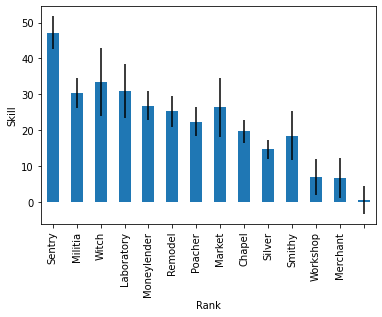

In [5]:
import matplotlib.pyplot as plt


skills = TrueSkill.get_skills(players, matches)
skills = skills.sort_values('lo', ascending=False)
confidence_interval = [skills.mu - skills.lo, skills.hi - skills.mu]
skills.plot(kind='bar', y='mu', yerr=confidence_interval, legend=False)
plt.xlabel('Rank')
plt.ylabel('Skill')
plt.show()

Hmm.... So TrueSkill ranks the cards not the openings, but we can fix that.

In [6]:
teams = list(set(matches.better.tolist() + matches.worse.tolist()))
team_skills = {'team': [], 'mu': [], 'sigma': []}
for t in teams:
    t1, t2 = t
    s1, s2 = skills.loc[t1], skills.loc[t2]
    team_skills['team'].append(t)
    team_skills['mu'].append(s1.mu + s2.mu)
    team_skills['sigma'].append((s1.sigma**2 + s2.sigma**2)**0.5)
team_skills = pd.DataFrame(team_skills)
team_skills['lo'] = team_skills.mu - 2*team_skills.sigma
team_skills['hi'] = team_skills.mu + 2*team_skills.sigma

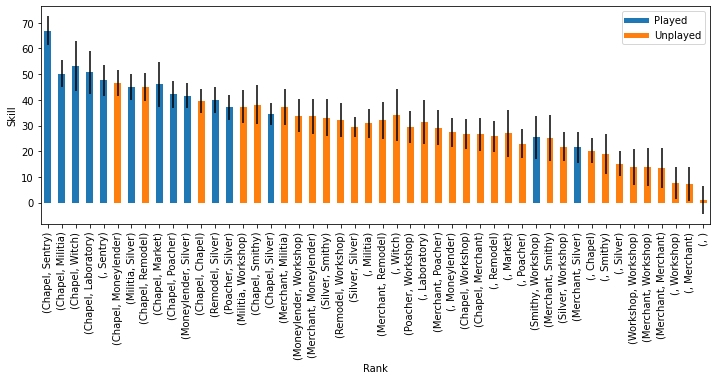

In [7]:
team_skills.sort_values('lo', inplace=True, ascending=False)
played = set(matches.better)
colors = ['C0' if p in played else 'C1' for p in team_skills.team]
confidence_interval = [team_skills.mu - team_skills.lo, team_skills.hi - team_skills.mu]
team_skills.plot(kind='bar', x='team', y='mu', yerr=confidence_interval, legend=False, figsize=(12,4), color=colors)
plt.plot([], linewidth=5, color='C0', label='Played')
plt.plot([], linewidth=5, color='C1', label='Unplayed')
plt.legend(labels=['Played', 'Unplayed'])
plt.xlabel('Rank')
plt.ylabel('Skill')
plt.show()

TrueSkill's rankings don't look reasonable. Is (Chapel, Sentry) really that much better than everything else? Why is (Chapel, Chapel) ranked higher than (Chapel, Silver)? We could bootstrap the ratings like we did in Part 1 to get more accurate estimates of uncertainty, but this would not solve our problem. There is a more fundamental issue at play. TrueSkill is based on the assumption that the skill of a team of players is the sum of the skills of the players. While this assumption may be correct in some settings, it is certainly not for dominion openings. We're going to need a different approach.

## The Plan

What makes a good opening? You might imagine that there are several factors that might indicate whether or not an opening is good. Does it help you trash your bad cards? Does it help you hit 5? Does it slow down your opponent? And so on. When considering these factors, you probably weigh some more heavily than others. Sure the additional actions a Village gives you will be nice later on, but might it make more sense to prioritize some terminal actions first? We don't know what the optimal factors are or how to weigh them, but maybe they can be inferred from the data.

This described approach is called a [latent factor model](https://people.engr.tamu.edu/huangrh/Spring16/papers_course/matrix_factorization.pdf), "latent" because we don't know what the factors are, but we can let the model learn some anyway. Latent factor models are commonly used to build recommender systems. They gained popularity in large part because of their success in the Netflix Prize, a competition which awarded *one million dollars* to the first team to beat the accuracy of Netflix's recommender system by 10%. That said, we are not predicting users' ratings of movies on Netflix... are we? Actually we sort of are: Burning Skull is the only user and the openings are the movies!

That said, we do not know what Burning Skull would rate any of these openings, only his preferences, so we will have to adapt our model accordingly. Lucky for us, [this problem](https://arxiv.org/pdf/1205.2618.pdf) has also been tackled by the recommender system community. Instead of training our model to predict Burning Skull's rating for each opening, we can train our model to predict the probability Burning Skull will prefer one opening over another given the difference in our predicted ratings of those openings. We can do this by minimizing the logistic loss or cost function on the data (like a logistic regression) using gradient descent. Gradient descent essentially computes the gradient (i.e., the derivatives or slopes associated with our variables) and takes a small step down the gradient over and over again to minimize the loss function.

Lastly, let's not forget why went down this path in the first place. Let's consider why (Chapel, Chapel) is not a great opening. Chapel is a great opening card because it fulfills a important role: removing bad cards from the deck. Since one Chapel does this job excellently, a second Chapel is less useful, and buying something to fulfill a different role would be more valuable than any marginal improvement in removing bad cards from our deck. So generally adding the skills of cards makes more sense when those cards fulfill different roles, but less sense when they fulfill the same role. To capture this effect of decreasing marginal utility we can use the tanh function which maps the range (-∞, ∞) to (-1, 1). So in addition to adding the factors of the cards in an opening, we will map each sum of factors to the range (-1, 1) using the tanh function.

That was a lot to unpack, so let's summarize our plan:
1. Pick a small number of factors, k, to infer from the data
1. For each card, create k variables representing the latent factors of that card
1. Create k variables representing the weights corresponding to each factor
1. To get the factors for an opening, sum up the factors of its cards and apply the tanh function to capture the effect of decreasing marginal utility
1. To get the skill for an opening, multiply each component of its factors by its corresponding weight and add them all up
1. Predict the probability one opening is better than another using the difference in skills
1. Optimize the variables using gradient descent to minimize the logistic loss function given our data

## TensorSkill

Let's code it up in TensorFlow!

In [8]:
import tensorflow as tf
from tqdm import tqdm


class TensorSkill(object):
    def __init__(self, players, **config):
        self.players = list(players)
        self.n = len(players)
        self.player_ids = dict(zip(players, range(self.n)))
        
        self.k = int(config.get('k', 1))
        self.alpha = float(config.get('alpha', 0))
        self.train_steps = int(config.get('train_steps', 10000))
        
        initializer = tf.initializers.get(config.get('initializer', 'glorot_uniform'))
        self.factors = tf.Variable(initializer([self.n, self.k]))
        self.weights = tf.Variable(initializer([self.k]))
        self.optimizer = tf.optimizers.get(config.get('optimizer', 'adam'))
        
    def _get_player_ids(self, players):
        return [self.player_ids[p] for p in players]
        
    @tf.function
    def _skill(self, teams):
        total = 0
        for i in range(teams.shape[1]):
            total += tf.nn.embedding_lookup(self.factors, teams[:, i])
        return tf.reduce_sum(self.weights*tf.tanh(total), axis=1)

    @tf.function
    def _loss(self, better, worse):
        y, z = self._skill(better), self._skill(worse)
        logistic_loss = -tf.reduce_mean(tf.math.log(tf.sigmoid(y - z)))
        reg = tf.reduce_sum(self.factors**2) + tf.reduce_sum(self.weights**2)
        return (1 - self.alpha)*logistic_loss + self.alpha*reg
    
    @tf.function
    def _train_step(self, better, worse):
        with tf.GradientTape() as tape:
            batch_loss = self._loss(better, worse)
        gradients = tape.gradient(batch_loss, [self.factors, self.weights])
        self.optimizer.apply_gradients(zip(gradients, [self.factors, self.weights]))
    
    def train(self, matches):
        drawn_matches = matches[matches.drawn == True]
        drawn_matches.rename(columns={'better': 'worse', 'worse': 'better'}, inplace=True)
        matches = pd.concat([matches, drawn_matches]).reset_index(drop=True)
        better = tf.constant(matches.better.apply(self._get_player_ids).tolist())
        worse = tf.constant(matches.worse.apply(self._get_player_ids).tolist())
        for i in range(self.train_steps):
            self._train_step(better, worse)
    
    def get_skill(self, team):
        return self._skill(tf.constant([self._get_player_ids(team)])).numpy()[0]
    
    @classmethod
    def get_skills(cls, players, matches, config):
        model = cls(players, **config)
        model.train(matches)
        teams = list(set(matches.better.tolist() + matches.worse.tolist()))
        skills = pd.Series({t: model.get_skill(t) for t in teams})
        return skills.sort_values(ascending=False)

    @classmethod
    def get_bootstrapped_skills(cls, players, matches, config, samples=1000, alpha=0.05):
        skills = cls.get_skills(players, matches, config).to_frame('mu')
        for i in tqdm(range(samples)):
            skills[i] = cls.get_skills(players, matches.sample(frac=1, replace=True), config)
        skills['lo'] = 2*skills.mu - skills[list(range(samples))].quantile(1 - alpha/2, axis=1)
        skills['hi'] = 2*skills.mu - skills[list(range(samples))].quantile(alpha/2, axis=1)
        return skills[['mu', 'lo', 'hi']]

Note that in addition to k (the number of latent factors) we have a few other parameters. These parameters control the training process and are known as hyperparameters. The first, alpha, controls how close to zero the learned variables are, which is important to [limit the model complexity](https://en.wikipedia.org/wiki/Regularization_(mathematics)). The second, train_steps, controls how many iterations of gradient descent to perform. The third, initializer, controls how we pick the initial values of our variables (typically small random numbers are good). The last, optimizer, controls which "flavor" of gradient descent to use (there are many, but [Adam](https://arxiv.org/pdf/1412.6980.pdf) is popular).

We only really need to worry about k and alpha. These hyperparameters should be optimized as well, but we cannot use gradient descent. Instead, we can optimize them using cross validation. This involves randomly splitting the training data into multiple bins, training on all but one of those bins, validating the performance on the left out bin, and repeating this procedure till all the bins have been used for validation. The average performance from cross validation gives a good indication of the model's generalization performance given the hyperparameters, so we can test many hyperparameters sets to find the best ones. As you can imagine this is a lengthy process, so for now let's just pick some reasonable values (and leave finding the optimal hyperparameters as an exercise for the reader xD). We can imagine only a handful of factors are relevant, so let's pick 5 for k. For alpha, which ranges from 0 to 1, we should lean toward the largest value that works to limit the model complexity (think [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor)). After trying 0.1, 0.01, and 0.001, setting alpha to 0.001 looks reasonable.

Ok enough talk. Let's train our model and plot the results!

In [9]:
import warnings
warnings.filterwarnings('ignore')


config = {'k': 5, 'alpha': 0.001}
skills = TensorSkill.get_skills(players, matches, config)

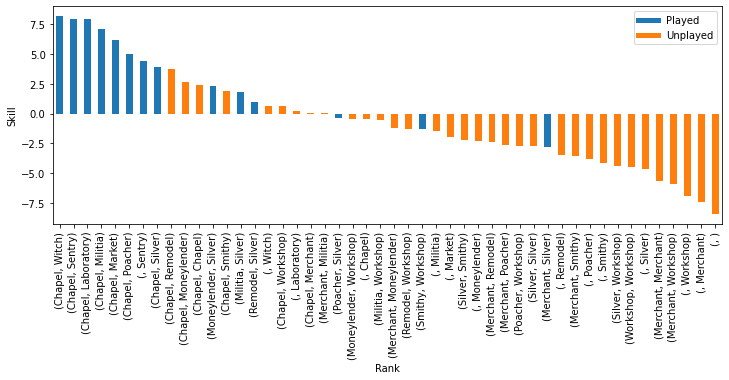

In [10]:
played = set(matches.better.unique())
colors = ['C0' if p in played else 'C1' for p in skills.index]
skills.plot(kind='bar', color=colors, figsize=(12, 4))
plt.plot([], linewidth=5, color='C0', label='Played')
plt.plot([], linewidth=5, color='C1', label='Unplayed')
plt.legend(labels=['Played', 'Unplayed'])
plt.xlabel('Rank')
plt.ylabel('Skill')
plt.show()

These skills look quite reasonable! Our skill estimates for the played openings seem to match those from Part 1 for the most part, except for (Chapel, Militia), whose skill estimate seems to have decreased from first to fourth, but this is in line with the [Council Room](http://councilroom.com/openings) rankings, so it is plausible. (Chapel, Silver) is rated higher than (Chapel, Chapel), phew! Buying nothing is a bad opening (who knew? xD). (Remodel, Chapel) is the top unplayed opening, neck and neck with (Silver, Chapel), so perhaps it is worth giving a try if you haven't already!

Let's compare with the [Council Room](http://councilroom.com/openings) rankings as in Part 1.

In [11]:
ranks = pd.read_html('http://councilroom.com/openings')[0]
ranks.cards = ranks.cards.apply(lambda x: tuple(sorted(x.split(' / '))))
ranks.cards = ranks.cards.apply(lambda x: ('', x[0]) if len(x) < 2 else x)
ranks[['level', 'uncertainty']] = ranks['skill range'].str.split(' ± ', expand=True).astype(float)
ranks = ranks[ranks.cards.isin(skills.index)].sort_values('level', ascending=False)

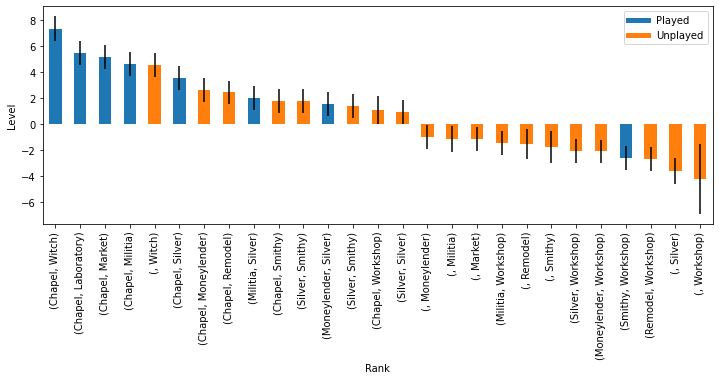

In [12]:
played = set(matches.better.unique())
colors = ['C0' if p in played else 'C1' for p in ranks.cards]
ranks.plot(kind='bar', x='cards', y='level', yerr='uncertainty', legend=False, figsize=(12, 4), color=colors)
plt.plot([], linewidth=5, color='C0', label='Played')
plt.plot([], linewidth=5, color='C1', label='Unplayed')
plt.legend(labels=['Played', 'Unplayed'])
plt.xlabel('Rank')
plt.ylabel('Level')
plt.show()

I'm not sure why (Silver, Smithy) appears twice in Council Room's rankings lol. Anyway, Council Room seems to rank (, Witch) much higher than our model. If I had to guess, the addition of Sentry in the second edition of the base set has lessened the sting of Witch to some extent. Otherwise our results look pretty consistent, maybe disagreeing more as the openings get lower in the rankings, but that's okay since we care more about the better openings.

One additional benefit of explicitly modeling the cards is that we can see what the model learned about the cards! To do this we can use dimensionality reduction ([principal component analysis](https://scikit-learn.org/stable/modules/decomposition.html#pca)) to plot our factors in 2 dimensions, then we can use a clustering algorithm ([k-means clustering](https://scikit-learn.org/stable/modules/clustering.html#k-means)) to identify cards with similar factors.

In [13]:
model = TensorSkill(players, **config)
model.train(matches)
factors = model.factors.numpy()

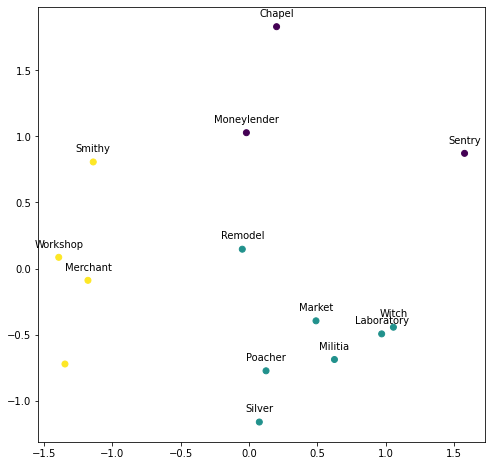

In [14]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


reduced_factors = PCA(n_components=2).fit_transform(factors)
x, y = reduced_factors.T
clustering = KMeans(n_clusters=3)
clustering.fit(reduced_factors)
c = clustering.labels_

fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=c)
for i, txt in enumerate(model.players):
    plt.annotate(txt, (x[i], y[i]), textcoords='offset points', xytext=(0,10), ha='center')
plt.show()

Look how similar cards are grouped together. Roughly, one direction corresponds to trashing, while the other corresponds to cost. So it seems trashing and cost were the most important factors the model learned to make its predictions!

Now let's examine the clusters. The number of clusters we choose is a subjective choice (e.g., Sentry or Remodel could probably be singled out into their own clusters), but with 3, the following clusters tend to emerge:
1. Trashers - Chapel, Moneylender, Sentry (and sometimes Remodel)
1. High value cards - Silver, Poacher, Market, Militia, Laboratory, Witch (and sometimes Remodel)
1. Low value cards - '', Workshop, Merchant, Smithy

## The Finale

As in Part 1, let's bootstrap our skills to obtain uncertainty estimates for our final rankings. Unfortunately, this will take much longer than before, but again, uncertainty is something we can't ignore with this limited dataset, so be patient! And remember, any rankings of openings should only be used as a guide, and you should be especially skeptical of the rankings for openings that weren't played in the dataset!

In [15]:
skills = TensorSkill.get_bootstrapped_skills(players, matches, config)

100%|██████████| 1000/1000 [1:45:19<00:00,  6.32s/it]


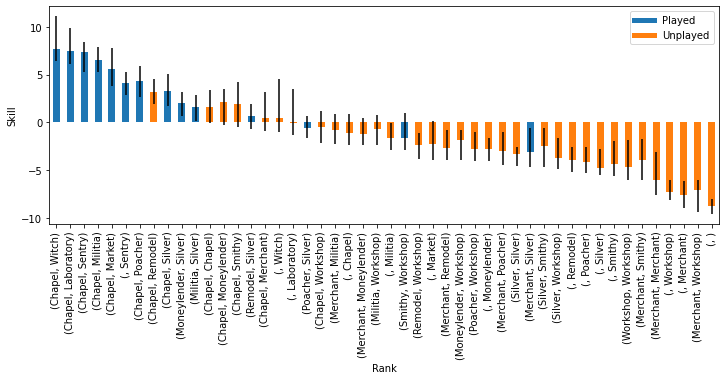

In [16]:
played = set(matches.better.unique())
skills.sort_values('lo', ascending=False, inplace=True)
confidence_interval = [skills.mu - skills.lo, skills.hi - skills.mu]
colors = ['C0' if p in played else 'C1' for p in skills.index]
skills.plot(kind='bar', y='mu', yerr=confidence_interval, legend=False, figsize=(12, 4), color=colors)
plt.plot([], linewidth=5, color='C0', label='Played')
plt.plot([], linewidth=5, color='C1', label='Unplayed')
plt.legend(labels=['Played', 'Unplayed'])
plt.xlabel('Rank')
plt.ylabel('Skill')
plt.show()

Enjoy! : )